In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from math import pi

import pennylane as qml

#original numpy 
import numpy as onp

In [142]:
from collections import Counter, OrderedDict

## Trapped Ion Circuit in Pennylane

### qml.ops.Rot 

$$
  R(\phi,\theta,\omega) = \begin{bmatrix}
       e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
      e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
      \end{bmatrix}
$$

### qml.ops.IsingXX: 
$$
 XX(\phi) = \begin{bmatrix}
          \cos(\phi / 2) & 0 & 0 & -i \sin(\phi / 2) \\
         0 & \cos(\phi / 2) & -i \sin(\phi / 2) & 0 \\
          0 & -i \sin(\phi / 2) & \cos(\phi / 2) & 0 \\
         -i \sin(\phi / 2) & 0 & 0 & \cos(\phi / 2)
     \end{bmatrix}
$$
 

In [12]:
# circuit depth
num_layers = 3

# number of qubits
num_wires  = 4

# set Pauli Z measurment operator
Z_obs = qml.PauliZ(0)
for j in range(1,num_wires):
    Z_obs = Z_obs @ qml.PauliZ(j)

## Pennylane Ion Circuit

In [235]:
num_samples = 5000
#exact_tensornet = qml.device("default.tensor", wires=num_wires, contraction_method="greedy")
#mps_tensornet = qml.device("default.tensor", wires=num_wires, representation="mps")
dev_qubit = qml.device("default.qubit", wires=num_wires, shots=num_samples)
dev = dev_qubit

## Random Parameters

In [236]:
# parameters for single qubit gates
theta_single = onp.random.rand(num_layers,num_wires,3)
# parameters for MS gates
theta_two = onp.random.rand(num_layers,num_wires-1,1)

In [237]:
# generate all bit strings
bit_strings = ion_circuit.device.generate_basis_states(num_wires)

In [225]:
bit_strings = ion_circuit.device.generate_basis_states(num_wires).astype(onp.int32)
bit_strings[bit_strings == 0] = -1

In [239]:
@qml.qnode(dev)
def ion_circuit(qubit_theta, MS_theta, bitflip=False):
    if bitflip:
        (flip_qubit, flip_layer) = tuple([onp.random.randint(0,num_wires),onp.random.randint(0,num_layers)])
        
    for ell in range(num_layers):
        # random single qubit unitaries 
        qml.broadcast(qml.Rot, wires=dev.wires, pattern='single', parameters=qubit_theta[ell])
        # Chain of Molmer-Sorensen gates 
        qml.broadcast(qml.ops.IsingXX, wires=dev.wires, pattern='chain',  parameters=MS_theta[ell])
        # Insert random bitflip
        if bitflip and flip_layer == ell:
            qml.ops.RX(pi,wires=flip_qubit)
    # final layer of single qubit rotations  
    qml.broadcast(qml.Rot, wires=dev.wires, pattern='single', parameters=qubit_theta[-1])
    # return samples
    return [qml.sample(qml.PauliZ(j)) for j in range(num_wires)]

In [240]:
def sample_bitstrings(theta_single, theta_two, BF=False):
    circuit_samples = ion_circuit(theta_single, theta_two, bitflip=BF).T
    counts = Counter(map(tuple, circuit_samples.tolist()))
    ordered_counts = OrderedDict(sorted(counts.items()))
    
    return onp.array(list(ordered_counts.values()))/num_samples

### Generate Samples

In [262]:
bitstring_probs = sample_bitstrings(theta_single, theta_two, BF=False)

In [263]:
print(ion_circuit.draw())

 0: ──Rot(0.874, 0.675, 0.854)──────╭IsingXX(0.238)───Rot(0.714, 0.297, 0.252)───────────────────────────────╭IsingXX(0.916)───────────────Rot(0.564, 0.86, 0.338)─────────────────────────────╭IsingXX(0.269)─────────────Rot(0.564, 0.86, 0.338)───────────────────────────────────────────────────────┤ Sample[Z] 
 1: ──Rot(0.896, 0.0585, 0.000485)──╰IsingXX(0.238)──╭IsingXX(0.249)─────────────Rot(0.00315, 0.134, 0.458)──╰IsingXX(0.916)──────────────╭IsingXX(0.000757)─────────Rot(0.248, 0.722, 0.851)──╰IsingXX(0.269)────────────╭IsingXX(0.767)────────────Rot(0.248, 0.722, 0.851)────────────────────────────┤ Sample[Z] 
 2: ──Rot(0.899, 0.615, 0.829)───────────────────────╰IsingXX(0.249)────────────╭IsingXX(0.00217)─────────────Rot(0.585, 0.747, 0.796)────╰IsingXX(0.000757)────────╭IsingXX(0.388)─────────────Rot(0.349, 0.117, 0.889)──╰IsingXX(0.767)───────────╭IsingXX(0.338)────────────Rot(0.349, 0.117, 0.889)──┤ Sample[Z] 
 3: ──Rot(0.983, 0.191, 0.786)────────────────────────────────────────

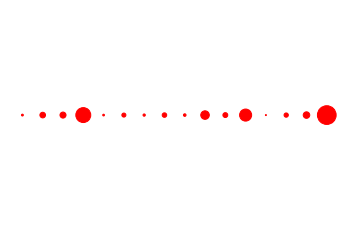

In [264]:
# task 1
plt.scatter(range(len(bitstring_probs)),onp.zeros(len(bitstring_probs)), 1000*onp.array(bitstring_probs), 'r')
plt.axis('off');

### Random bitflips in circuit

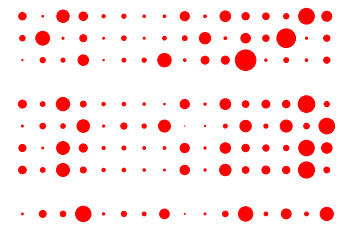

In [266]:
#Task 2
num_runs = 10
# Set BF = True to add random bitflips
bitflip_probs = [sample_bitstrings(theta_single, theta_two, BF=True) for _ in range(num_runs)]

# plot speckle pattern
for rr in range(num_runs):
    if bitflip_probs[rr].shape[0] == 2**num_wires:
        plt.scatter(range(len(bitstring_probs)),rr*onp.ones(len(bitstring_probs)), 1000*bitflip_probs[rr], 'r')
plt.axis('off');